In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

from database.connection import sql_connection
from database.dataset import dataset_config
import lightgbm as lgb
from skopt.space import Real, Integer
from modules.interface import RunModel, RunOptimization
from plots import plots

import numpy as np
import pandas as pd

import gc
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import math
import platform
import seaborn as sns
from pathlib import Path

In [2]:
# Função para extrair dados de um arquivo SQLite e retornar um DataFrame - Não alterar
def extrair_dados_sqlite(caminho_arquivo, nome_tabela):
    # Conectando ao arquivo SQLite

    conn = sqlite3.connect(caminho_arquivo)
    
    # Definindo a consulta SQL que deseja executar
    sql_query = f"SELECT * FROM {nome_tabela}"
    
    # Executando a consulta SQL e carregando os resultados em um DataFrame
    dataframe = pd.read_sql_query(sql_query, conn)
    
    # Fechando a conexão com o banco de dados
    conn.close()
    
    return dataframe

# Extrair dados do terceiro arquivo SQLite

# Base robusta: script OU notebook
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    # Jupyter / IPython
    BASE_DIR = Path.cwd()

# Voltar um diretório e entrar em database/data/lorenzetti
LORENZETTI_DIR = (BASE_DIR / '..' / 'database' / 'data' / 'lorenzetti').resolve()

qrings_relevant_data_lorenzetti = pd.concat(
    [
        extrair_dados_sqlite(LORENZETTI_DIR / 'StdRings.db', 'events'),
        extrair_dados_sqlite(LORENZETTI_DIR / 'QRings.db', 'events'),
        extrair_dados_sqlite(LORENZETTI_DIR / 'ClusterData.db', 'events')
    ],
    axis=1
)

gc.collect()

def normalize_qrings(df,layers):
    for layer in layers.keys():
        
        rings = layers[layer]["rings"]
        qrings = layers[layer]["qrings"]

        for i in range(1, len(rings)):

            std = df[f"StdRings_{rings[i]}"]
            qr_cols = [f"QuarterRings_{j}" for j in range(qrings[4*i-3], qrings[4*i]+1)]
            print('-------------------',std)
            print('-------------------',qr_cols)
            df.loc[:, qr_cols] = (
                df[qr_cols]
                .div(std.abs(), axis=0)
                .where(std.ne(0), 0)
            )

    return df

def diff_qrings_energy(df, layers):
    # 1. Criamos um dicionário para armazenar todas as novas colunas
    new_cols = {}

    for layer in layers.keys():
        qrings = layers[layer]["qrings"]
        rings = layers[layer]["rings"]

        for i in range(1, len(rings)):
            # Definindo os nomes das colunas de origem
            q1 = f"QuarterRings_{qrings[4*i-3]}"
            q2 = f"QuarterRings_{qrings[4*i-2]}"
            q3 = f"QuarterRings_{qrings[4*i-1]}"
            q4 = f"QuarterRings_{qrings[4*i]}"

            # 2. Em vez de df[novo] = ..., guardamos no dicionário
            name_1_3 = f"diff_QuarterRings_{qrings[4*i-3]}_{qrings[4*i-1]}"
            name_2_4 = f"diff_QuarterRings_{qrings[4*i-2]}_{qrings[4*i]}"
            
            new_cols[name_1_3] = df[q1] - df[q3]
            new_cols[name_2_4] = df[q2] - df[q4]

    # 3. Concatenamos todas as novas colunas de uma vez só ao final
    # axis=1 significa concatenar colunas (horizontalmente)
    df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

    return df

def vectorize_rings_energy(df, layers):
    new_cols = {}
    
    for layer in layers.keys():
        rings = layers[layer]["rings"]
        qrings = layers[layer]["qrings"]

        for i in range(1, len(rings)):
            # Nomes das colunas de diferença (calculadas no passo anterior)
            col_dx = f"diff_QuarterRings_{qrings[4*i-2]}_{qrings[4*i]}"
            col_dy = f"diff_QuarterRings_{qrings[4*i-3]}_{qrings[4*i-1]}"
            
            dx = df[col_dx]
            dy = df[col_dy]

            # Módulo do vetor usando a hipotenusa
            mod_name = f"vec_mod_{rings[i]}"
            new_cols[mod_name] = np.hypot(dx, dy)

            # Ângulo em radianos ou graus
            ang_name = f"vec_ang_{rings[i]}"
            # np.arctan2 já lida com a divisão por zero e quadrantes corretamente
            new_cols[ang_name] = np.arctan2(dy, dx)

            # Flag booleana convertida para int (se o vetor é nulo)
            zero_name = f"vec_is_zero_{rings[i]}"
            new_cols[zero_name] = (new_cols[mod_name] == 0).astype(int)

    # Concatena todas as métricas vetoriais de uma vez
    df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)
    
    return df

def vectorize_layer_energy(df, layers):
    new_cols = {}

    for layer in layers.keys():
        rings = layers[layer]["rings"]
        qrings = layers[layer]["qrings"]
        
        # Inicializamos com zeros no formato da Series do DataFrame
        dx_sum = 0.0
        dy_sum = 0.0

        for i in range(1, len(rings)):
            # Somando as diferenças de todos os anéis daquela camada
            dx_sum += df[f"diff_QuarterRings_{qrings[4*i-2]}_{qrings[4*i]}"]
            dy_sum += df[f"diff_QuarterRings_{qrings[4*i-3]}_{qrings[4*i-1]}"]

        # Calculamos as métricas da camada inteira
        mod_name = f"vec_mod_layer_{layer}"
        ang_name = f"vec_ang_layer_{layer}"
        zero_name = f"vec_is_zero_layer_{layer}"

        new_cols[mod_name] = np.hypot(dx_sum, dy_sum)
        new_cols[ang_name] = np.arctan2(dy_sum, dx_sum)
        new_cols[zero_name] = (new_cols[mod_name] == 0).astype(int)

    # Inserção única para evitar fragmentação
    df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

    return df

layers = {
    "PS":  {"rings": list(range(0, 8)),   "qrings": list(range(0, 29))},
    "EM1": {"rings": list(range(8, 72)),  "qrings": list(range(29, 282))},
    "EM2": {"rings": list(range(72, 80)), "qrings": list(range(282, 311))},
    "EM3": {"rings": list(range(80, 88)), "qrings": list(range(311, 340))},
    "H1":  {"rings": list(range(88, 92)), "qrings": list(range(340, 353))},
    "H2":  {"rings": list(range(92, 96)), "qrings": list(range(353, 366))},
    "H3":  {"rings": list(range(96, 100)),"qrings": list(range(366, 379))},
}

#qrings_relevant_data_lorenzetti=normalize_qrings(qrings_relevant_data_lorenzetti, layers)
qrings_relevant_data_lorenzetti=diff_qrings_energy(qrings_relevant_data_lorenzetti, layers)
qrings_relevant_data_lorenzetti=vectorize_rings_energy(qrings_relevant_data_lorenzetti, layers)
qrings_relevant_data_lorenzetti=vectorize_layer_energy(qrings_relevant_data_lorenzetti, layers)
dataframe=qrings_relevant_data_lorenzetti

print((dataframe.shape))

(66677, 975)


In [ ]:
from database.dataset.new_data import DataBuilder

# Definição dos bins de entrada
bins_et = {'cluster_et':[5000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 150000, 200000, 250000, 900000, 3000000]}
bins_eta = {'cluster_eta':[0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5]}
# Lista para armazenar o resultado final
params = []

# Extrai as listas de valores dos dicionários
et_values = bins_et['cluster_et']
eta_values = bins_eta['cluster_eta']

# Itera sobre cada intervalo de eta (ex: [0, 0.6], [0.6, 0.8], ...)
for i in range(len(eta_values) - 1):
    eta_interval = [eta_values[i], eta_values[i+1]]
    
    # Para cada intervalo de eta, itera sobre cada intervalo de et
    for j in range(len(et_values) - 1):
        et_interval = [et_values[j], et_values[j+1]]
        
        # Cria a estrutura de dicionário para a combinação atual
        param_combination = [
            {'cluster_eta': eta_interval},
            {'cluster_et': et_interval}
        ]
        
        # Adiciona a combinação à lista final
        params.append(param_combination)
# print(len(params))

data=DataBuilder(dataframe=dataframe).run(
    topology='raw', 
    train_size=0.7, 
    random_state=1, 
    model='default', 
    bins_size=None
    )

[raw] Executando lógica Raw Default...
new_processing_print ['StdRings_0', 'StdRings_1', 'StdRings_2', 'StdRings_3', 'StdRings_4', 'StdRings_5', 'StdRings_6', 'StdRings_7', 'StdRings_8', 'StdRings_9', 'StdRings_10', 'StdRings_11', 'StdRings_12', 'StdRings_13', 'StdRings_14', 'StdRings_15', 'StdRings_16', 'StdRings_17', 'StdRings_18', 'StdRings_19', 'StdRings_20', 'StdRings_21', 'StdRings_22', 'StdRings_23', 'StdRings_24', 'StdRings_25', 'StdRings_26', 'StdRings_27', 'StdRings_28', 'StdRings_29', 'StdRings_30', 'StdRings_31', 'StdRings_32', 'StdRings_33', 'StdRings_34', 'StdRings_35', 'StdRings_36', 'StdRings_37', 'StdRings_38', 'StdRings_39', 'StdRings_40', 'StdRings_41', 'StdRings_42', 'StdRings_43', 'StdRings_44', 'StdRings_45', 'StdRings_46', 'StdRings_47', 'StdRings_48', 'StdRings_49', 'StdRings_50', 'StdRings_51', 'StdRings_52', 'StdRings_53', 'StdRings_54', 'StdRings_55', 'StdRings_56', 'StdRings_57', 'StdRings_58', 'StdRings_59', 'StdRings_60', 'StdRings_61', 'StdRings_62', 'Std

In [4]:
space_lgbm = [
    Real(name='learning_rate', low = 0.01 , high = 0.9),
    Integer(name='num_leaves', low = 200, high = 1000),
    Integer(name='max_depth', low = 200, high = 1000),
    Real(name='feature_fraction', low = 0.5 , high = 1),
    Real(name='bagging_fraction', low = 0.7 , high = 1),
    Integer(name='bagging_freq', low = 1, high = 10),
    Real(name='lambda_l1',low = 0.0, high = 1),
    Real(name='lambda_l2',low = 0.5, high = 1)
]

fixed_params_lgbm = {
    "boosting_type": "gbdt",
    'objective': 'mae', 
    'metric': 'mae', 
    'num_iterations ': 200,
    'random_state': 1, 
    'n_jobs': -1, 
    'verbose': -1
}

calibration_kwargs = {'callbacks':[lgb.early_stopping(stopping_rounds=5, verbose=False)]}
optimization_kwargs = {'n_initial_points': 1,
                        'n_calls': 2,
                        'initial_point_generator': 'lhs',
                        'random_state': 1,

                       
                       }

optimizer_lgbm = RunOptimization()
results=optimizer_lgbm.run(opt_class='gp_minimize',
    model_class="lgbm",
    datasets=data,
    space=space_lgbm, 
    fixed_params=fixed_params_lgbm,
    metric='mae',
    calibration_kwargs=calibration_kwargs,
    optimization_kwargs= optimization_kwargs
)

13
[-inf, 0, 0.6, 0.8, 1.2, 1.37, 1.52, 1.8, 2.0, 2.2, 2.5, 3.5, inf]
filtered_mask shape:  (1041, 4) lower_bound:  0 upper_bound:  0.6
filtered_mask shape:  (498, 4) lower_bound:  0.6 upper_bound:  0.8
filtered_mask shape:  (1522, 4) lower_bound:  0.8 upper_bound:  1.2
filtered_mask shape:  (848, 4) lower_bound:  1.2 upper_bound:  1.37
filtered_mask shape:  (806, 4) lower_bound:  1.37 upper_bound:  1.52
filtered_mask shape:  (1781, 4) lower_bound:  1.52 upper_bound:  1.8
filtered_mask shape:  (1423, 4) lower_bound:  1.8 upper_bound:  2.0
filtered_mask shape:  (1822, 4) lower_bound:  2.0 upper_bound:  2.2
filtered_mask shape:  (2911, 4) lower_bound:  2.2 upper_bound:  2.5
filtered_mask shape:  (7352, 4) lower_bound:  2.5 upper_bound:  3.5


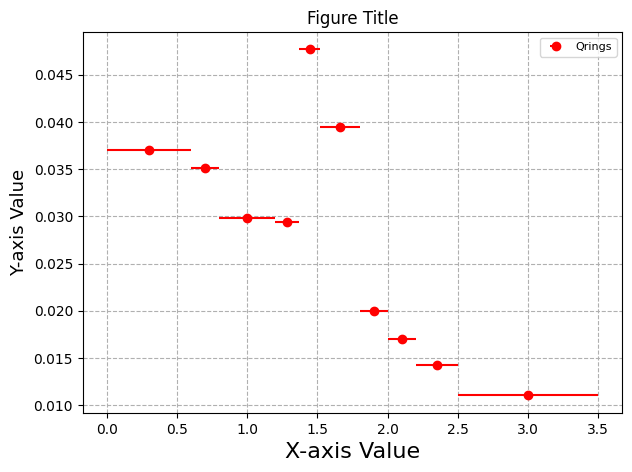

8
[-inf, 5000, 10000, 20000, 30000, 40000, 100000, inf]
filtered_mask shape:  (52, 4) lower_bound:  5000 upper_bound:  10000
filtered_mask shape:  (6128, 4) lower_bound:  10000 upper_bound:  20000
filtered_mask shape:  (10182, 4) lower_bound:  20000 upper_bound:  30000
filtered_mask shape:  (3550, 4) lower_bound:  30000 upper_bound:  40000
filtered_mask shape:  (92, 4) lower_bound:  40000 upper_bound:  100000


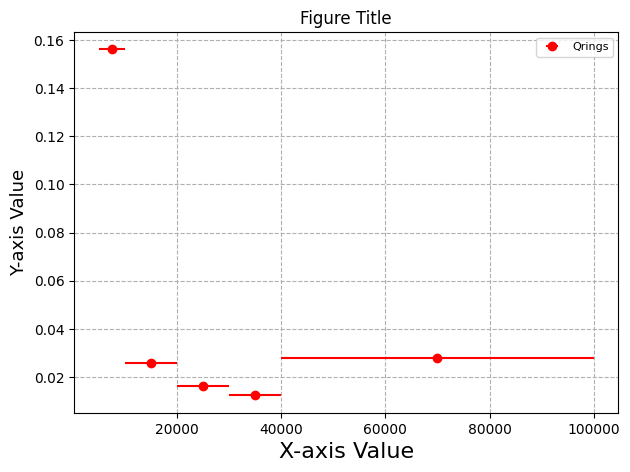

In [7]:
config=[{'label':'Qrings',
         'fmt':'o',
         'color':'r'}]

plot_eta=plots.PlotConfig(optimizer_lgbm.optimizer, dataframe, bins_eta)
# dados=plot_eta._set_plot()
# print('return set_plot', type(dados), len(dados))
plot_eta.plot_errorbars(plot_eta._set_plot(), config)

plot_et=plots.PlotConfig(optimizer_lgbm.optimizer, dataframe, bins_et)
# dados=plot_eta._set_plot()
# print('return set_plot', type(dados), len(dados))
plot_et.plot_errorbars(plot_et._set_plot(), config)